In [1]:
# load libraries 
library(ggplot2)
library(dplyr)
library(ggtree)
library(stats)
library(lattice)
library(cowplot)
library(forcats)
library(stringr)
library(ape)
library(RColorBrewer)
library(tidyr)

library(biomaRt)
library(vctrs)
library(Gviz)
library(ggrepel)
library(extrafont)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.t

In [8]:
# general settings
theme_set(theme_classic() + theme(text = element_text(size=16, family = "sans"),
         plot.title = element_text(hjust = 0.5,size=16,face="bold")))
lineage_colors <- c("#e69f00","firebrick","#6794a7", "#014d64", "#01a2d9" ,
                    "#7ad2f6" ,"#00887d", "#76c0c1", "lightblue", "gray"  )
pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#999999","#009E73","#D55E00")
pop_labels <- c("African","East Asian","European","Admixed American", "South Asian","Lima")

g2g_L2_colors <- c('#E64B35FF','#4DBBD5FF')
options(StringsAsFactors=FALSE)
options(repr.plot.width = 10, repr.plot.height = 7)

# SF1 Genomic inflation factor ($\lambda_{gc}$) of all 1,267 Mtb genome-wide association analysis

## SF1a Histogram of $\lambda_{gc}$

In [4]:
lambdagc <- read.table("../data/saige-lambdagc.txt",h=T)

lambdaHist <- ggplot(lambdagc,aes(lambdagcspa))+geom_histogram() + 
    xlab(expression(lambda[gc]))+ylab("Count") + 
    ylab(expression(paste("Number of ", italic(Mtb), " SNP-host SNP GWAS"),sep=""))
range(lambdagc$lambdagcspa)
median(lambdagc$lambdagcspa)
mean(lambdagc$lambdagcspa)

[1] 0.9402415 1.0381093

[1] 1.003401

[1] 1.00364

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"


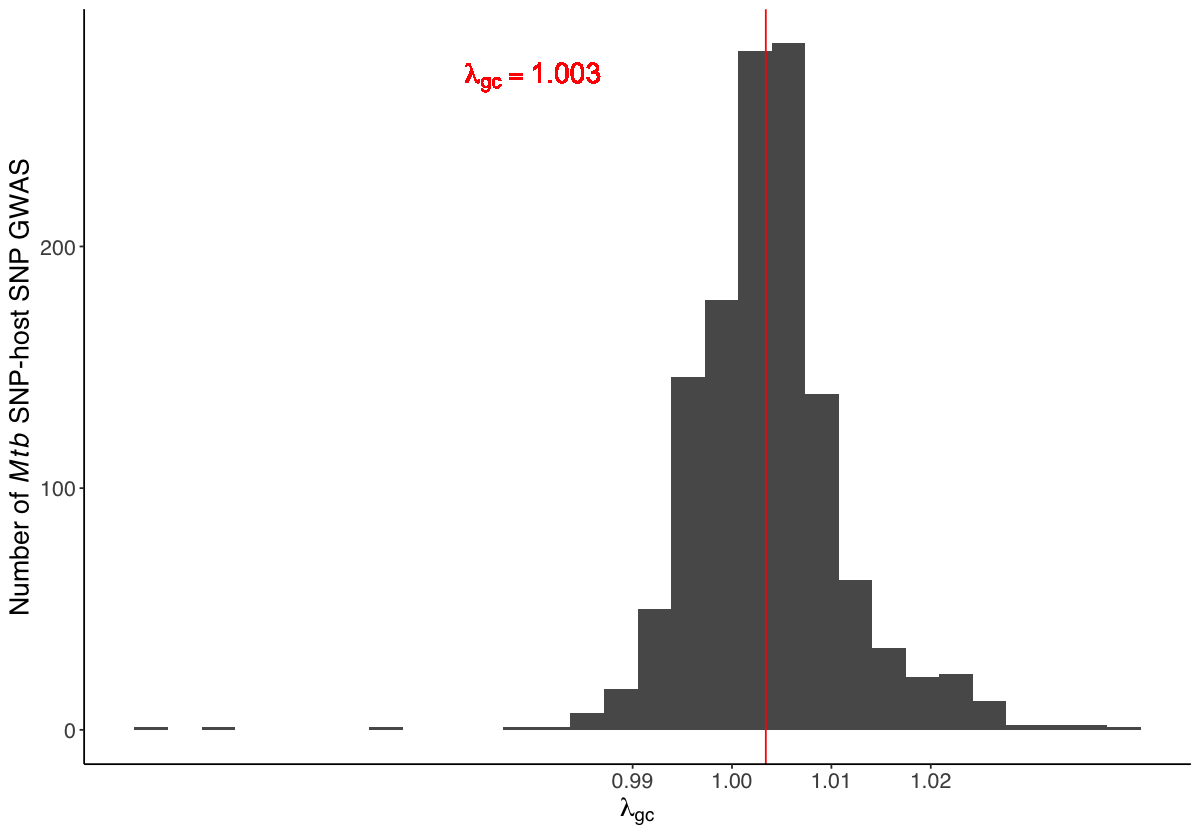

In [5]:
lambdaHist <- lambdaHist + 
    geom_vline(aes(xintercept = median(lambdagcspa)),col='red') +
    scale_x_continuous(breaks = c(0.99,1,1.01,1.02,1.05)) + 
    geom_text(x=0.98, y=270, label=expression(lambda[gc]==1.003),color="red",size=6)

lambdaHist

## SF1b Q-Q plot of all association p-values

In [6]:
pvals <- scan("../data/pvals.txt.gz",as.numeric())

Warning message in file(file, "r"):
"cannot open file '../data/pvals.txt.gz': No such file or directory"


ERROR: Error in file(file, "r"): cannot open the connection


In [ ]:
#range(pvals)

# to calculate genomic inflation factor (lambda_gc)
  chisq <- qchisq(1-pvals,1)
  lambdagc <- median(chisq)/qchisq(0.5,1)
lambdagc

[1] 1.004819

In [ ]:
pos97 <- read.table("../data/saige-Pos271640_stats.txt.gz",h=T)
pos97pvals <- pos97$p.value


In [ ]:
# to calculate genomic inflation factor (lambda_gc)
pos97chisq <- qchisq(1-pos97pvals,1)
pos97lambdagc <- median(pos97chisq)/qchisq(0.5,1)
pos97lambdagc

[1] 1.00806

In [ ]:
m <- length(pvals)
m

ERROR: Error in eval(expr, envir, enclos): object 'pvals' not found


In [ ]:
# script for qq-plot with 95% confidence interval, modified based on 
# https://genome.sph.umich.edu/wiki/Code_Sample:_Generating_QQ_Plots_in_R

qqunif.plot<-function(pvalues, lambda,
                      should.thin=T, thin.obs.places=2, thin.exp.places=2, 
                      xlab=list(expression(paste("Expected ",-log[10], " (p)")),cex=1.5),
                      ylab=list(expression(paste("Observed ",-log[10], " (p)")),cex=1.5), 
                      draw.conf=TRUE, conf.points=1000, conf.col="lightgray", conf.alpha=.05,
                      already.transformed=FALSE, pch=20, aspect="iso", prepanel=prepanel.qqunif,
                      par.settings=list(superpose.symbol=list(pch=pch)), ...) {
  
  
  #error checking
  if (length(pvalues)==0) stop("pvalue vector is empty, can't draw plot")
  if(!(class(pvalues)=="numeric" || 
       (class(pvalues)=="list" && all(sapply(pvalues, class)=="numeric"))))
    stop("pvalue vector is not numeric, can't draw plot")
  if (any(is.na(unlist(pvalues)))) stop("pvalue vector contains NA values, can't draw plot")
  if (already.transformed==FALSE) {
    if (any(unlist(pvalues)==0)) stop("pvalue vector contains zeros, can't draw plot")
  } else {
    if (any(unlist(pvalues)<0)) stop("-log10 pvalue vector contains negative values, can't draw plot")
  }
  
  
  # to calculate genomic inflation factor (lambda_gc), takes forever to plot all points, so going to keep lambdagc as an external output
  # chisq <- qchisq(1-pvalues,1)
  # lambda <- round(median(chisq)/qchisq(0.5,1),2)
  #lambda <- 1.005
  keyname <- as.expression(bquote(lambda[GC] == .(lambda)))
  
  grp<-NULL
  n<-1
  exp.x<-c()
  if(is.list(pvalues)) {
    nn<-sapply(pvalues, length)
    rs<-cumsum(nn)
    re<-rs-nn+1
    n<-min(nn)
    if (!is.null(names(pvalues))) {
      grp=factor(rep(names(pvalues), nn), levels=names(pvalues))
      names(pvalues)<-NULL
    } else {
      grp=factor(rep(1:length(pvalues), nn))
    }
    pvo<-pvalues
    pvalues<-numeric(sum(nn))
    exp.x<-numeric(sum(nn))
    for(i in 1:length(pvo)) {
      if (!already.transformed) {
        pvalues[rs[i]:re[i]] <- -log10(pvo[[i]])
        exp.x[rs[i]:re[i]] <- -log10((rank(pvo[[i]], ties.method="first")-.5)/nn[i])
      } else {
        pvalues[rs[i]:re[i]] <- pvo[[i]]
        exp.x[rs[i]:re[i]] <- -log10((nn[i]+1-rank(pvo[[i]], ties.method="first")-.5)/(nn[i]+1))
      }
    }
  } else {
    n <- length(pvalues)+1
    if (!already.transformed) {
      exp.x <- -log10((rank(pvalues, ties.method="first")-.5)/n)
      pvalues <- -log10(pvalues)
    } else {
      exp.x <- -log10((n-rank(pvalues, ties.method="first")-.5)/n)
    }
  }
  
  
  #this is a helper function to draw the confidence interval
  panel.qqconf<-function(n, conf.points=1000, conf.col="gray", conf.alpha=.05, ...) {
    require(grid)
    conf.points = min(conf.points, n-1);
    mpts<-matrix(nrow=conf.points*2, ncol=2)
    for(i in seq(from=1, to=conf.points)) {
      mpts[i,1]<- -log10((i-.5)/n)
      mpts[i,2]<- -log10(qbeta(1-conf.alpha/2, i, n-i))
      mpts[conf.points*2+1-i,1]<- -log10((i-.5)/n)
      mpts[conf.points*2+1-i,2]<- -log10(qbeta(conf.alpha/2, i, n-i))
    }
    grid.polygon(x=mpts[,1],y=mpts[,2], gp=gpar(fill=conf.col, lty=0), default.units="native")
  }
  
  #reduce number of points to plot
  if (should.thin==T) {
    if (!is.null(grp)) {
      thin <- unique(data.frame(pvalues = round(pvalues, thin.obs.places),
                                exp.x = round(exp.x, thin.exp.places),
                                grp=grp))
      grp = thin$grp
    } else {
      thin <- unique(data.frame(pvalues = round(pvalues, thin.obs.places),
                                exp.x = round(exp.x, thin.exp.places)))
    }
    pvalues <- thin$pvalues
    exp.x <- thin$exp.x
  }
  gc()
  
  prepanel.qqunif= function(x,y,...) {
    A = list()
    A$xlim = range(x, y)*1.05
    A$xlim[1]=0
    A$ylim = A$xlim
    return(A)
  }

  #draw the plot
  plt <- xyplot(pvalues~exp.x, groups=grp, xlab=xlab, ylab=ylab, aspect=aspect,
         prepanel=prepanel, scales=list(axs="i",cex=1.2), pch=pch,col=1,
         key=list(corner=c(0.2,0.8),cex=1.5,
                  text=list(keyname)
         ),
         panel = function(x, y, ...) {
           if (draw.conf) {
             panel.qqconf(n, conf.points=conf.points, 
                          conf.col=conf.col, conf.alpha=conf.alpha)
           };
           panel.xyplot(x,y, ...);
           panel.abline(0,1);
         }, par.settings=par.settings, ...
  )
  return(plt)
}

In [ ]:
pos97mhc <- read.table("../data/saige-Pos271640_mhc_stats.txt.gz",h=T)
pos97mhcpvals <- pos97mhc$p.value
length(pos97pvals)
length(pos97mhcpvals)
toplotP <- c(pvals[sample(m,1e7)],pos97mhcpvals)

length(toplotP)

[1] 434280

[1] 47500

ERROR: Error in eval(expr, envir, enclos): object 'pvals' not found


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"


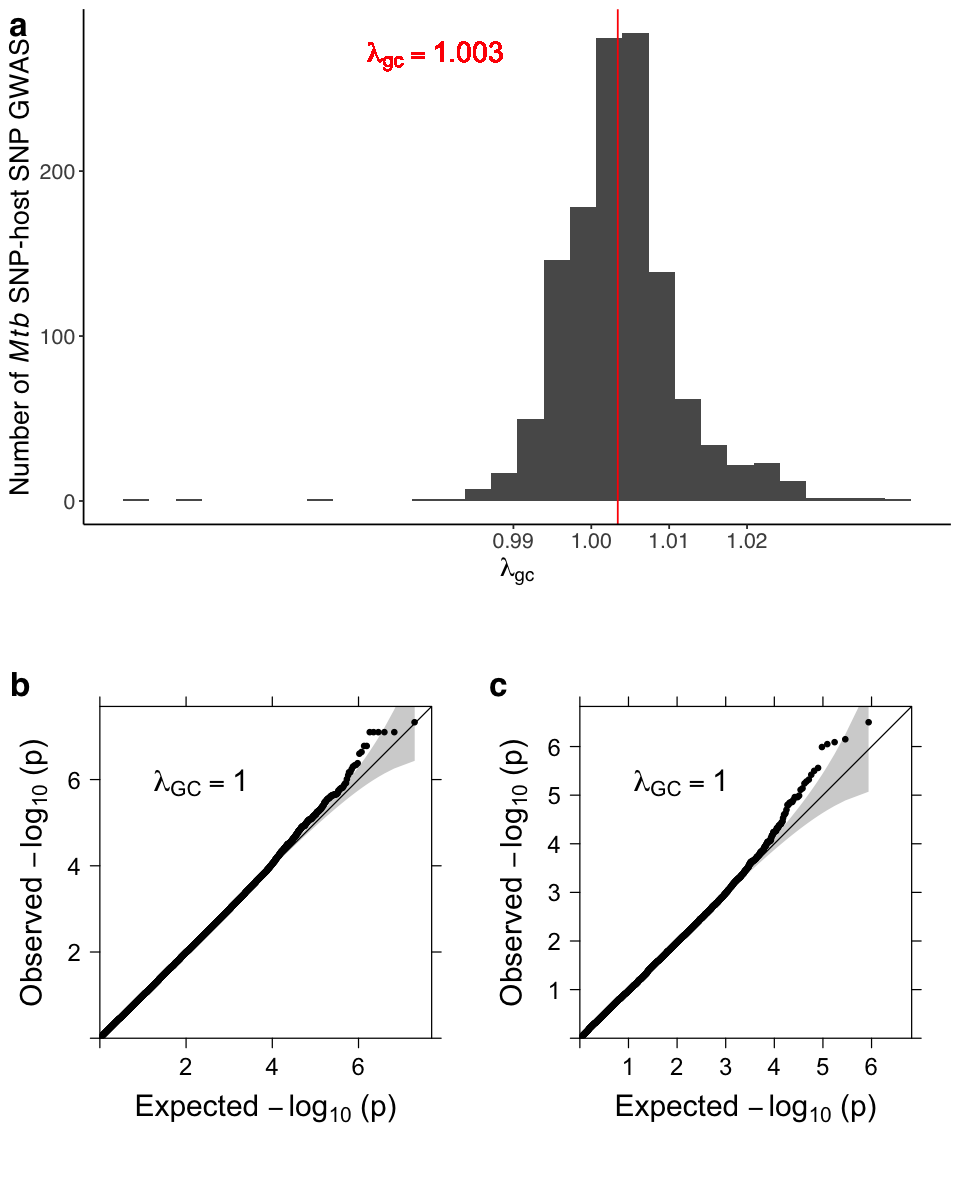

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 10)

ggdraw() +
  draw_plot(lambdaHist, x = 0, y = 0.5,width = 1, height = .5) +
  draw_plot(qqunif.plot(toplotP,lambda=1.00), x = 0, y = 0, width = .5, height = .5) +
  draw_plot(qqunif.plot(pos97pvals,lambda=1.00), x = 0.5, y = 0, width = .5, height = .5) +
  draw_plot_label(label = c("a", "b","c"), size = 20,font="bold",
                  x = c(0, 0,0.5), y = c(1, 0.45,0.45)) +
 theme(plot.background = element_rect(fill="white", color = NA))

ggsave("../figures/SF1_pvals.pdf",width=9,height=6)

# SF2 - permutaiton p-value 

In [ ]:
permpvals <- read.table("../data/saige-perm-pvals.txt")
bonf <- 5e-8/1267
bonf
minpvals <- permpvals[,14]
threshold <- minpvals[order(minpvals)][length(minpvals)*0.05]
threshold
range(minpvals)

[1] 3.94633e-11

[1] 5.90926e-07

[1] 2.60054e-07 4.89114e-03

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`)."
Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"
Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`)."
Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"
Warning message in is.na(x):
"is.na() applied to non-(list or vector) of type 'expression'"


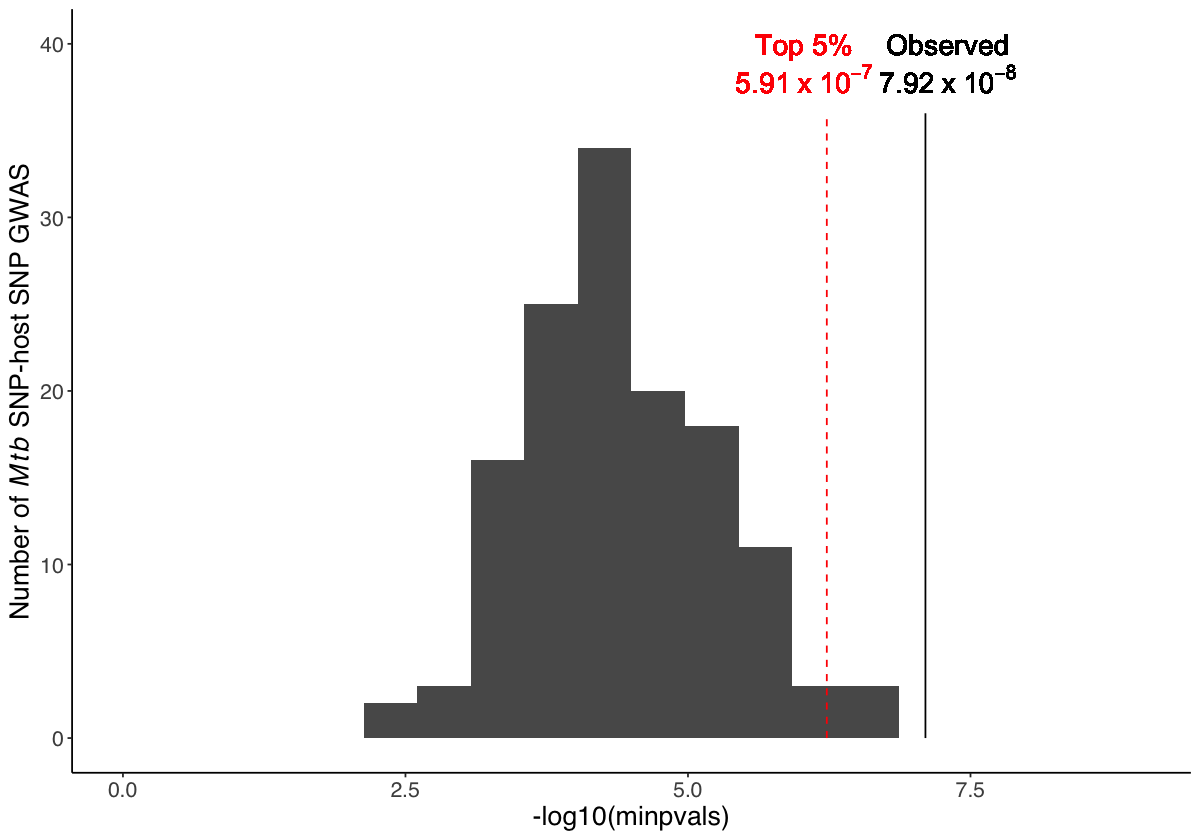

In [ ]:
a <- 40

observed <- 7.92e-8

perm.plt <- ggplot(data.frame(minpvals),aes(-log10(minpvals))) + geom_histogram(bins=20) + 
    geom_text(x=-log10(threshold)-.2,y=a,label="Top 5%",size=6,col="red") +
    geom_text(x=-log10(threshold)-.2,y=a-2,label=expression(5.91~x~10^{-7}),size=6,col="red") +
    ylab(expression(paste("Number of ", italic(Mtb), " SNP-host SNP GWAS"),sep="")) +
    ylim(0,a) + xlim(0,9) +
    geom_segment(data = data.frame( y= c(0,0), x = c(-log10(threshold),-log10(observed)), xend=c(-log10(threshold),-log10(observed)), yend=c(36,36)),
            aes(x, y, xend = xend, yend = yend),
               inherit.aes = FALSE, linetype = c(2,1), colour=c("red","black") ) +
               geom_text(x=-log10(observed)+.2,y=a,label="Observed", size=6,col="black") +
               geom_text(x=-log10(observed)+.2,y=a-2,label=expression(7.92~x~10^{-8}),size=6,col="black") 
options(repr.plot.width = 10, repr.plot.height = 7)
perm.plt
ggsave("../figures/SF2_permutation_pvals.pdf",width=9,height=6)

# SF3 - forestplot rs3130660-g2g

In [ ]:
stats <- read.table("../data/secondary_stats.txt",h=T,stringsAsFactors = F)
stats$OR <- exp(stats$beta)
stats$upper <- exp(stats$beta + 1.96*stats$se)
stats$lower <- exp(stats$beta - 1.96*stats$se)
stats

study,beta,se,pval,OR,upper,lower
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
original,2.30836,0.369931,7.91971e-08,10.05792,20.76824,4.870980
with_MtpPC,2.32254,0.396461,1.16525e-07,10.20155,22.18915,4.690206
with_year_of_diagnose,2.33887,0.370556,6.49340e-08,10.36951,21.43789,5.015736


In [ ]:

xlabs <- c( "GRM, age, sex", "GRM, age, sex, \n year of sample collection", 
    "GRM, age, sex, \nTop 10 Mtb PCs")
p1 <- stats %>% 
    mutate(name = fct_reorder(study, OR)) %>%
     ggplot(aes(x = study, y = OR,
                   ymin = lower, ymax = upper)) +
     geom_vline(aes(xintercept = name), col = "grey95", size = 20) +
     geom_hline(yintercept = 1, lty = 2) +
     geom_point() +
     geom_linerange() +
     coord_flip() +
     labs(x = NULL, y = NULL) +
     theme(plot.margin = margin(t = 5, r = -4, b = 5, l = 5)) +
     theme(
  text = element_text(size = 16),  # Adjust the font size (e.g., 16)
  axis.title = element_text(size = 16),  # X and Y axis titles
  axis.text = element_text(size = 16),  # Axis tick labels
  axis.ticks = element_line(size = 1),  # Adjust the tick size
  plot.title = element_text(size = 18)  # Title size
)

p1 <- p1 + scale_x_discrete(labels = xlabs)



Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


In [ ]:
p2 <- stats %>% 
    mutate(name = fct_reorder(study, OR),
           mean = round(OR, 2),
           mean = str_pad(OR, width = 4, side = "right", pad = "0"),
           lower = round(lower, 2),
           lower = as.character(lower),
           lower = ifelse(lower == "1", "1.00", lower),
           lower = str_pad(lower, width = 4, side = "right", pad = "0"),
           upper = round(upper, 2),
           upper = as.character(upper),
           upper = ifelse(upper == "1", "1.00", upper),
           upper = str_pad(upper, width = 4, side = "right", pad = "0"),
           ci = str_c(lower, " - ", upper)) %>%
    ggplot(aes(x = name)) +
    geom_vline(aes(xintercept = name), col = "grey95", size = 20) +
    geom_text(aes(label = as.character(round(OR,2)), y = 1),size=5) +
    geom_text(aes(label = ci, y = 1.045),size=5) +
    geom_text(aes(label = sprintf("%.2e", pval), y = 1.09),size=5) + 
    coord_flip(ylim = c(0.99, 1.1)) +
    theme(axis.title = element_blank(),
          axis.text = element_blank(),
          axis.ticks = element_blank(),
          axis.line.y = element_blank(),
          #axis.line.x = element_blank(),
          panel.border = element_blank(), 
          panel.grid = element_blank(), 
          plot.background = element_blank(),
          plot.margin = margin(t = 5, r = 5, b = 22.3, l = 0))


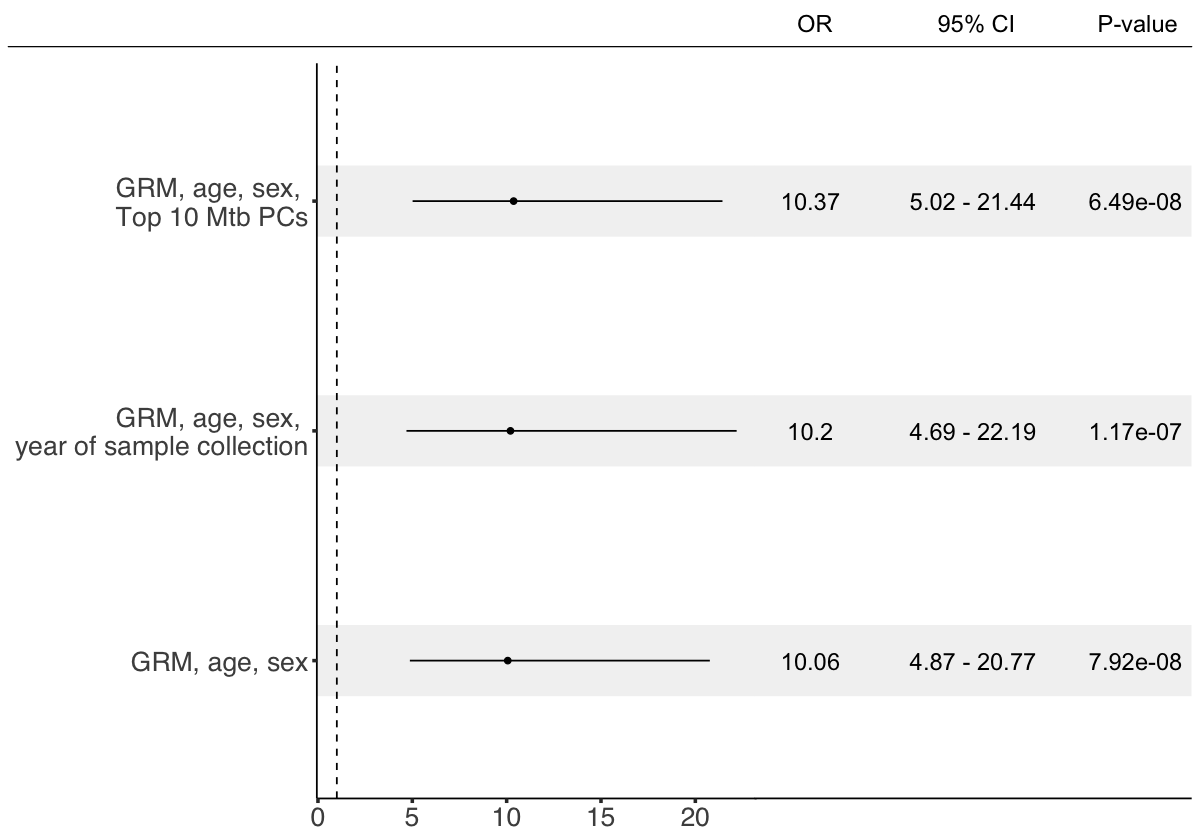

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 7)
bottom_row <- plot_grid(p1, p2, nrow = 1, rel_widths = c(1, .6)) 

top_row <- ggplot(data = tibble()) +
    geom_text(aes(y = 1, x = 0.02, label = ""), size = 5) +
    geom_text(aes(y = 1, x = 0.7, label = "OR"), size = 5) +
    geom_text(aes(y = 1, x = 0.85, label = "95% CI"), size = 5) +
        geom_text(aes(y = 1, x = 1, label = "P-value"), size = 5) +

    coord_cartesian(xlim = c(0, 1)) +
    theme_void() +
    theme(plot.margin = margin(t = 0, r = 5, b = 5, l = 5),
          axis.line.x.bottom = element_line())


plot_grid(top_row, bottom_row, ncol = 1, rel_heights = c(0.07, 1))

ggsave("../figures/SF3_forestplot.png",width=10,height=8)

# SF4a - collection year Mtb lineage distribution

[1] 104

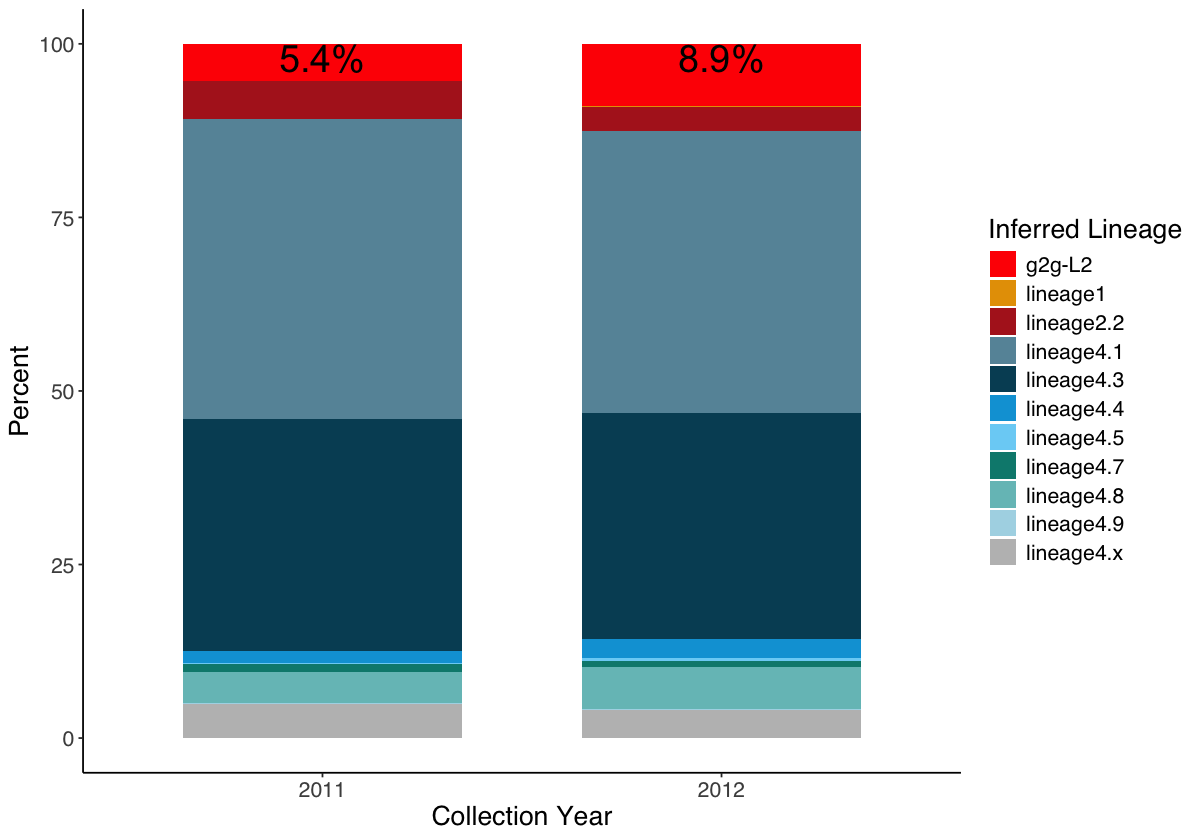

In [ ]:
g2gyr <- read.table("../data/g2gL2_collection_year.txt",h=T)
sum(g2gyr[g2gyr$lineage=="g2g-L2",]$n)

ggplot(g2gyr %>% filter(collection_year == "2011" | collection_year == "2012"), aes(x = factor(collection_year), y = perc*100, fill = factor(lineage))) +
  geom_bar(stat="identity", width = 0.7) +
  labs(x = "Collection Year", y = "Percent", fill = "lineage") +
    scale_fill_manual(values=c("red",lineage_colors),name="Inferred Lineage") +
      geom_text(data = g2gyr  %>% filter(collection_year == "2011" | collection_year == "2012")%>% filter(lineage=="g2g-L2"),
                aes(x = factor(collection_year),y=98,
                  label = scales::percent(perc)),size=8)

ggsave("../figures/SF4a_collection_year.pdf",width=7,height=5)

# SF5 genotype PCs and admixture analysis

## SF5a host PCs

In [ ]:
df <- read.table("../data/host_pcs.txt",h=T)
#val <- c(46.2,24.0)
df$region <- factor(df$REGION,levels = c("AFR","EAS","EUR","AMR","SAS","LIMAA"))
pcPlt <- ggplot(df,aes(x=V3,y=V4,colour=region))+geom_point()+
  #xlab(paste("PC1 (",round(val[1],1),"%)"))+ylab(paste("PC2 (",round(val[2],1),"%)"))+
    xlab("PC1")+ylab("PC2")+
  scale_color_manual(values=pop_colors,
    name="Populations",labels = )+
  theme(legend.position="top")

## SF5b Admixture analysis

In [ ]:
adm <- read.table("../data/host_admixture.txt",h=T)
table(adm$POP)
kdf5 <- adm %>% #filter(POP=="LIMA")  %>%
    mutate(id = row_number()) %>%
    gather("admixture","prop",K1,K2,K3,K4,K5) %>%
    mutate(likely_assignment = admixture[which.max(prop)],
          assignment_prob = max(prop)) %>%
    arrange(likely_assignment,desc(prop)) %>%
    ungroup() %>%
    mutate(id = fct_inorder(factor(id)))

kdf5$pop <- factor(kdf5$POP, levels=c("SAS","EAS","AFR","EUR","AMR","LIMA"))

admPlt <- ggplot(kdf5, aes(x = id,y=prop,
                    fill=factor(admixture, levels = c("K5","K1","K4","K3","K2")))) +
       geom_bar(stat = "identity") +
facet_grid(~(pop),scales="free",space="free") + 
scale_fill_manual(values=pop_colors) + 
  theme(
      legend.position="none",
    panel.spacing.x = unit(0.1, "lines"),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    panel.grid = element_blank()
  ) +
ylab("Ancestry propotion") + xlab("")


 AFR  AMR  EAS  EUR LIMA  SAS 
 661  347  504  503 1632  489 

## SF5 Combine two plots

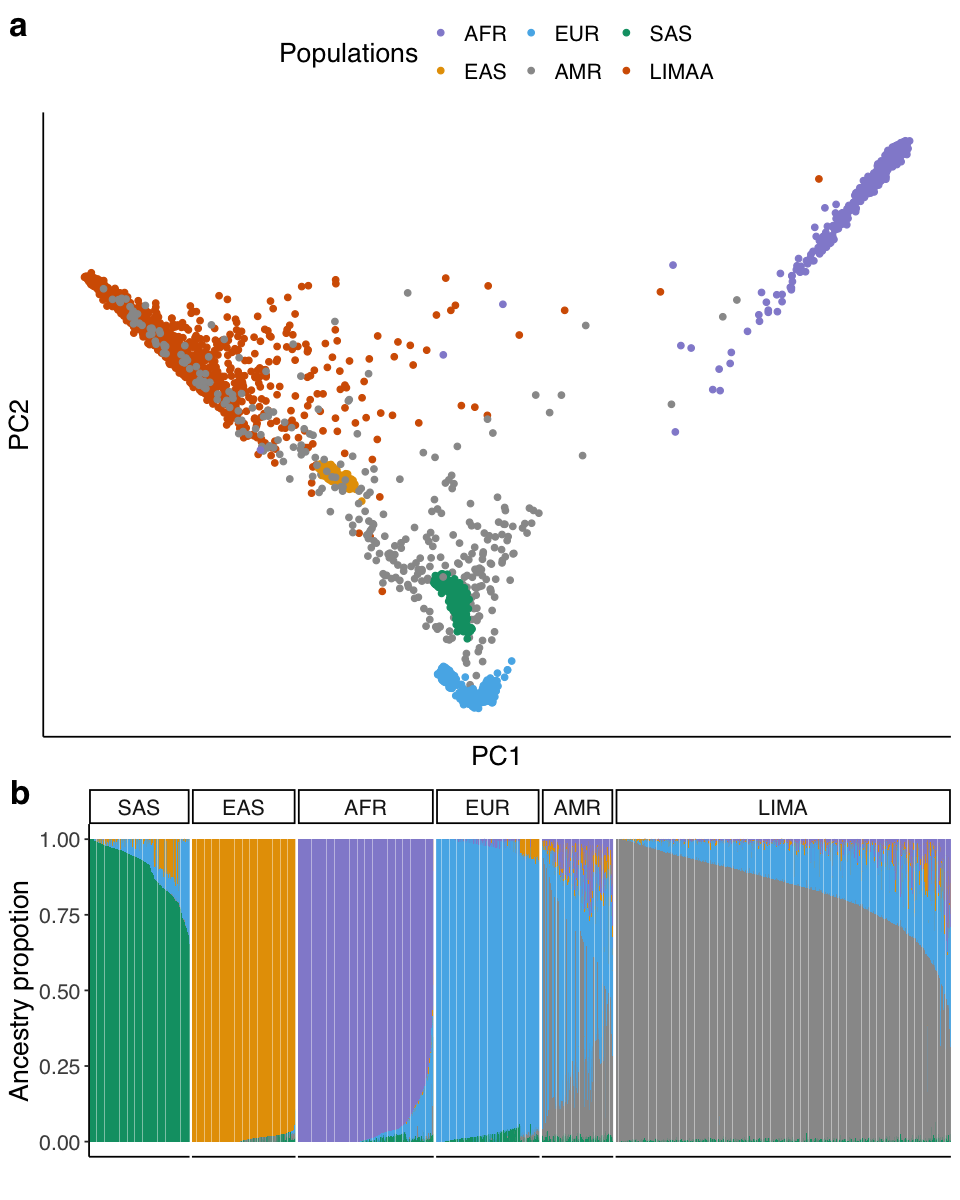

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 10)

ggdraw() +
  draw_plot(pcPlt+ theme(legend.position="top",    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_blank(),
    axis.ticks.y = element_blank()), x = 0, y = .35, width = 1, height = .65) +
  draw_plot(admPlt, x = 0, y = 0, width = 1, height = .35) +
  draw_plot_label(label = c("a", "b"), size = 20,font="bold",
                  x = c(0, 0), y = c(1, .36)) +
 theme(plot.background = element_rect(fill="white", color = NA))

 ggsave("../figures/SF5_human_pop_structure.pdf",width=8,height=10)

# SF6 Mtb lineage composition


In [9]:
## read the sampling information data set
info_all <- read.table("../data/g2g_info_with_geno.txt",h=T)
info <- info_all %>% filter(passg2gQC==1) 


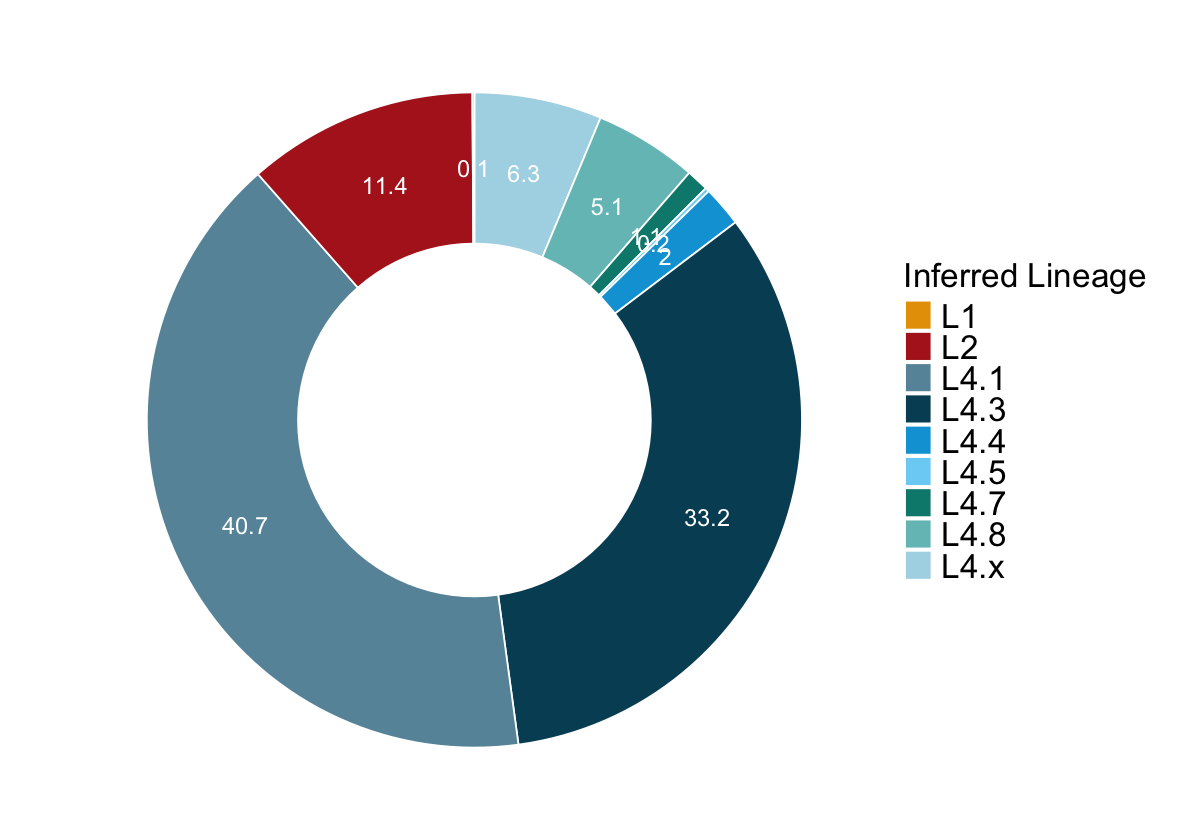

In [10]:
LineageCount <- data.frame(table(info$final_lineage))
LineageCount$prop <- round(LineageCount$Freq/nrow(info) * 100,1)
LineageCount <- LineageCount %>%
  arrange(desc(Var1)) %>%
  mutate(lab.ypos = cumsum(prop) - 0.5*prop)

# donut plot
propPlt <- ggplot(LineageCount, aes(x = 2, y = prop, fill = Var1)) +
  geom_bar(stat = "identity", color = "white") +
  coord_polar(theta = "y", start = 0)+
  geom_text(aes(y = lab.ypos, label = prop), color = "white",size=5)+
  scale_fill_manual(name="Inferred Lineage",values = lineage_colors) +
  theme_void()+
  xlim(0.5, 2.5)

propPlt <- propPlt + theme(legend.text = element_text(size=20),
                          legend.title = element_text(size=20))

propPlt
ggsave("../figures/SF6_lineage_distribution.pdf",width=9,height=6)


# SF7 L2vsL4 Manhattan

In [11]:
gwasResults <- read.table("../data/strainAssoc.txt.gz",h=F)
mhc <- read.table("../data/strainAssoc-mhc.txt.gz",h=T)

#define cosumized plots
names(gwasResults) <- c("CHR","BP","Z","pval")

gwasResults$P <- mhc[match(gwasResults$BP,mhc$BP),]$p.value

gwasResults$P <- ifelse(is.na(gwasResults$P) | gwasResults$CHR!=6, gwasResults$pval,gwasResults$P)

In [12]:
don <- gwasResults %>% filter(CHR<=23) %>%
  
  # Compute chromosome size
  group_by(CHR) %>% 
  summarise(chr_len=max(as.numeric(BP))) %>% 
  
  # Calculate cumulative position of each chromosome
  mutate(tot=cumsum(chr_len)-chr_len) %>%
  select(-chr_len) %>%
  
  # Add this info to the initial dataset
  left_join(gwasResults, ., by=c("CHR"="CHR")) %>%
  
  # Add a cumulative position of each SNP
  arrange(CHR, BP) %>%
  mutate( BPcum=BP+tot)

axisdf = don %>% group_by(CHR) %>% summarize(center=( max(BPcum) + min(BPcum) ) / 2 )

# the observed counts
lineageGWAS <- ggplot(don %>% na.omit(), aes(x=BPcum, y=-log10(P))) +
    
    # Show all points
    geom_point( aes(color=as.factor(CHR)), alpha=0.8, size=1) +
    scale_color_manual(values = rep(c("grey","darkblue"), 23 )) +
    
    # custom X axis:
    scale_x_continuous( label = axisdf$CHR, breaks= axisdf$center ) +
    #scale_y_continuous(expand = c(0, 0) ) +     # remove space between plot area and x axis

    xlab("Chromosome") + ylab("-log10(P)") + ylim(0,9) +
  
    # Custom the theme:
    theme( 
      legend.position="none",
      panel.border = element_blank()
    )


## SF7b lambdagc of L2vsL4

In [13]:
#' Create a quantile-quantile plot with ggplot2.
#'
#' Assumptions:
#'   - Expected P values are uniformly distributed.
#'   - Confidence intervals assume independence between tests.
#'     We expect deviations past the confidence intervals if the tests are
#'     not independent.
#'     For example, in a genome-wide association study, the genotype at any
#'     position is correlated to nearby positions. Tests of nearby genotypes
#'     will result in similar test statistics.
#'
#' @param ps Vector of p-values.
#' @param ci Size of the confidence interval, 95% by default.
#' @return A ggplot2 plot.
#' @examples
#' library(ggplot2)
#' gg_qqplot(runif(1e2)) + theme_grey(base_size = 24)
gg_qqplot <- function(ps, ci = 0.95) {
  n  <- length(ps)
  df <- data.frame(
    observed = -log10(sort(ps)),
    expected = -log10(ppoints(n)),
    clower   = -log10(qbeta(p = (1 - ci) / 2, shape1 = 1:n, shape2 = n:1)),
    cupper   = -log10(qbeta(p = (1 + ci) / 2, shape1 = 1:n, shape2 = n:1))
  )
  log10Pe <- expression(paste("Expected -log"[10], plain(P)))
  log10Po <- expression(paste("Observed -log"[10], plain(P)))
  ggplot(df) +
    geom_ribbon(
      mapping = aes(x = expected, ymin = clower, ymax = cupper),
      alpha = 0.1
    ) +
    geom_point(aes(expected, observed), size = 3) +
    geom_abline(intercept = 0, slope = 1, alpha = 0.5) +
    # geom_line(aes(expected, cupper), linetype = 2, size = 0.5) +
    # geom_line(aes(expected, clower), linetype = 2, size = 0.5) +
    xlab(log10Pe) +
    ylab(log10Po)
}

In [14]:
lambdagc <- median(gwasResults$Z^2,na.rm=T)/qchisq(0.5,1)
lambdagc
Lineagelambdagc <- gg_qqplot(gwasResults$P) +
  theme(
    panel.grid = element_blank()
  )
options(repr.plot.width=5, repr.plot.height=5)
Lineagelambdagc <- Lineagelambdagc + annotate("text",x=1,y=9,label=paste("~lambda[gc]==", round(lambdagc,2)),parse=T,size=6)

[1] 1.012731

## SF7c MHC region only

In [15]:
mhc_manhattan <- function(gwas=gwas,snpsOfInterest=NULL,cols = c(brewer.pal(6, 'Set1'), '#777777')){
    
    #assigning to HLA genes
    gwas$GENE<-"other"

    match_index<-function(gene='A',data=gwas,buffer=500){

       # patterns <- c(paste("SNPS",gene,sep="_"), paste("HLA",gene,sep="_"), paste("AA",gene,sep="_"))

        matches <- unique (c(grep(paste("SNPS",gene,sep="_"), gwas$SNP,value=FALSE),
                          grep(paste("HLA",gene,sep="_"), gwas$SNP,value=FALSE),
                            grep(paste("AA",gene,sep="_"), gwas$SNP,value=FALSE)))

        idx <- gwas$BP>=(gwas[matches[1],]$BP-buffer) & 
                          gwas$BP<=(gwas[matches[length(matches)],]$BP+buffer)
        return(idx)
    }

    genes<-c("A","B","C","DQA1","DQB1","DRB1")

    for (gene in genes){
        gwas[match_index(gene=gene,buffer=5000),]$GENE<-gene
    }

    snpsOfInterest<-gwas[gwas$P==min(gwas$P),]$SNP

    for (gene in genes){
    df<-gwas[gwas$GENE==gene,]
    snpsOfInterest<-c(snpsOfInterest,df[df$P==min(df$P),]$SNP[1])
    }

    # Prepare the dataset
    don <- gwas %>% 
  
      # Compute chromosome size
      group_by(CHR) %>% 
      summarise(chr_len=max(BP)) %>% 
  
      # Calculate cumulative position of each chromosome
      mutate(tot=cumsum(chr_len)-chr_len) %>%
      select(-chr_len) %>%
  
      # Add this info to the initial dataset
      left_join(gwas, ., by=c("CHR"="CHR")) %>%
  
      # Add a cumulative position of each SNP
      arrange(CHR, BP) %>%
      mutate( BPcum=BP+tot) %>%

      # Add highlight and annotation information
      mutate( is_highlight=ifelse(SNP %in% snpsOfInterest, "yes", "no")) %>%
      mutate( is_annotate=ifelse(SNP %in% snpsOfInterest, "yes", "no"))
    
    # Make the plot
    plt<-ggplot(don, aes(x=BPcum/1e6, y=-log10(P), color=GENE)) +
        # Show all points
        geom_point()+
        xlab("Chromosome 6 Position (Mb)")+ ylab("-log[10](P)")+
    # Add highlighted points
        geom_point(data=subset(don, is_highlight=="yes"), size=2) +

        # Add label using ggrepel to avoid overlapping
        scale_color_manual("HLA gene", values = cols )
    return(plt) 
}

In [16]:
lineageMHC <- read.table("../data/strainAssoc-mhc.txt.gz",h=T,stringsAsFactors = F)

names(lineageMHC) <- c("CHR","BP","SNP","BETA","SE","P")

L2MHC <- mhc_manhattan(gwas=na.omit(lineageMHC))


## Combine plots

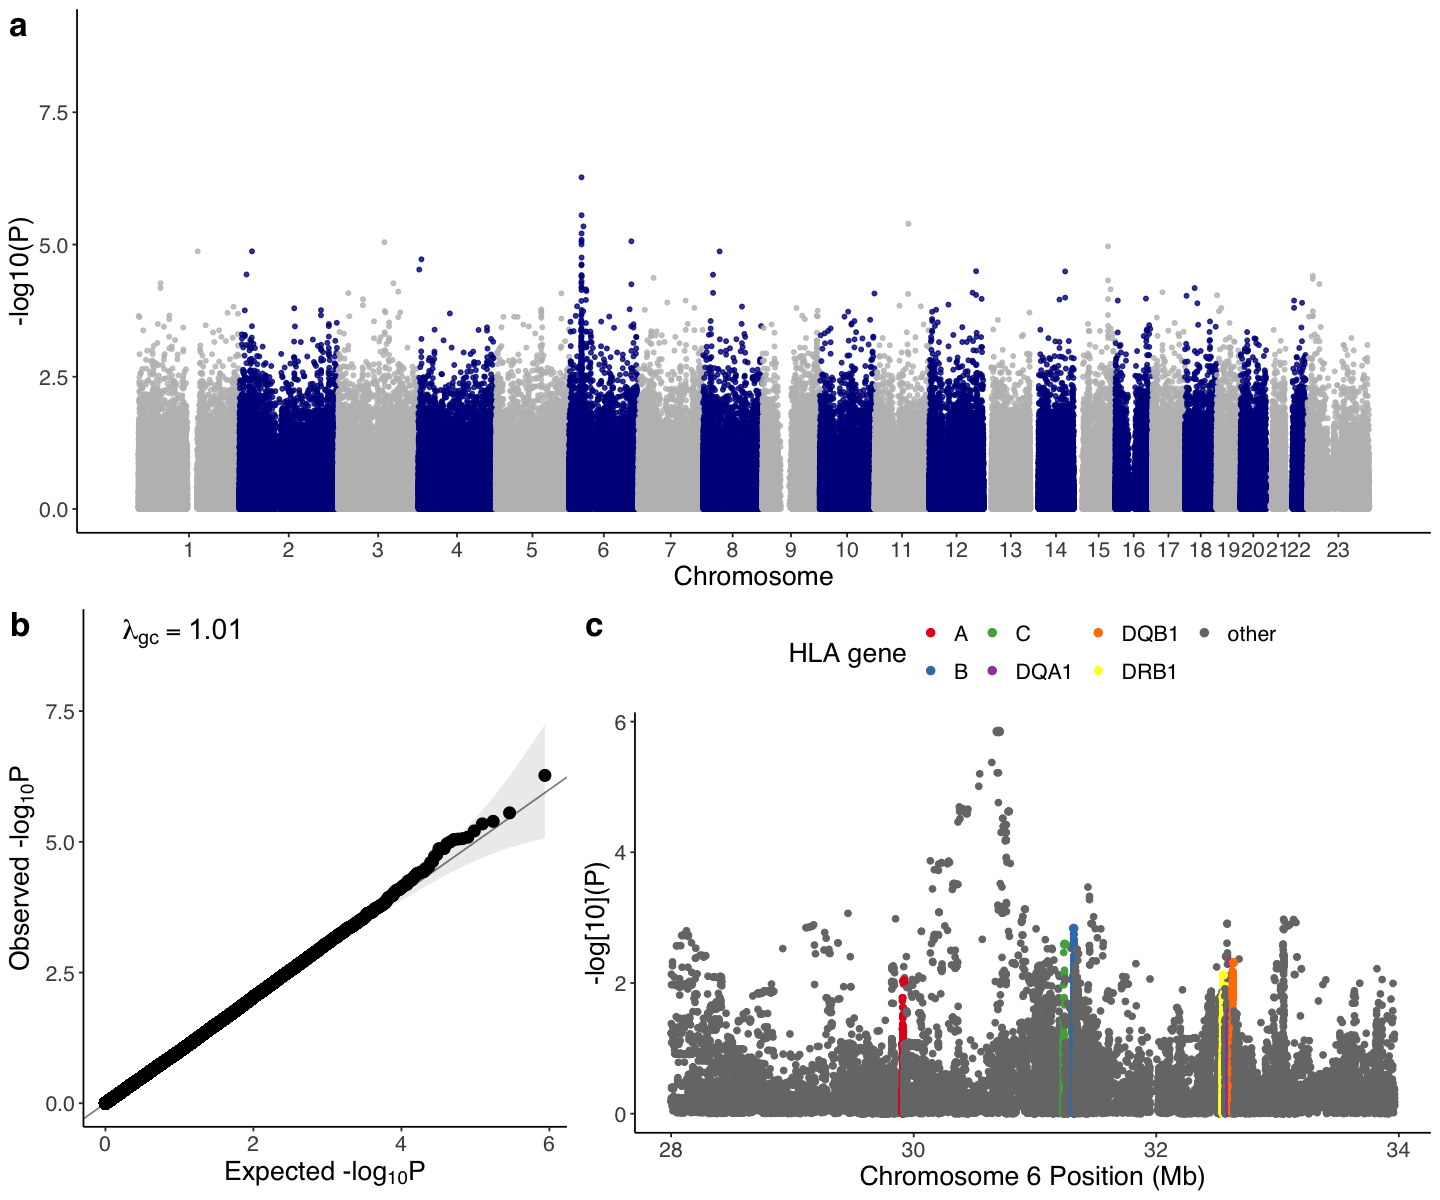

In [17]:
options(repr.plot.width = 12, repr.plot.height = 10)

ggdraw() +
  draw_plot(lineageGWAS, x = 0, y = .5, width = 1, height = .5) +
  draw_plot(Lineagelambdagc, x = 0, y = 0, width = .4, height = .5) +
  draw_plot(L2MHC + theme(legend.position = "top"), x = 0.4, y = 0, width = .6, height = 0.5) +
  draw_plot_label(label = c("a", "b", "c"), size = 20,font="bold",
                  x = c(0, 0, 0.4), y = c(1, .5, 0.5))

ggsave("../figures/SF7_lineage_assoc.pdf",width=12,height=10)

# SF8 FLOT1 coloc

## SF8a Locus plot of the FLOT1 region 

In [2]:
# read in gwas and eQTL summary stats
gwas <- read.table("../data/saige-Pos271640_mhc_stats.txt.gz", h=T)
eQTL <- read.table("../data/GTEx_v8_lung_eQTL_summary_stats.txt.gz",h=T)

In [3]:
gwas$ps <- as.numeric(gwas$POS)
gwas$rsid <- as.character(gwas$MarkerID)

r2 <- read.table("../data/rs3130660_r2.ld.gz",h=T) #TB g2g

gwas$r2 <- r2[match(gwas$rsid,r2$SNP_B),]$R2
gwas$r2 <- ifelse(is.na(gwas$r2),0,gwas$r2)
bins <- c(-Inf,0.2,0.4,0.6,0.8,1)

In [4]:
window <- 1000000
pos <- 30706361
minpos <- pos - window
maxpos <- pos + window
topsnp <- "rs3130660"

r2col <- c("#fef0d9","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds


In [14]:

pGWAS <- ggplot(data=gwas %>% filter(POS >= minpos & POS <=maxpos )) +
    geom_point(aes(x=ps,y=-log10(p.value),color=cut(r2,bins)),size=3) + # GWAS plot
    ylab(bquote(-log[10](P[g2g]))) + xlab("") 

pGWAS <- pGWAS + scale_x_continuous(expand = c(0, 0)) 
pGWAS <- pGWAS + geom_text(data=gwas %>% filter(rsid==topsnp),aes(x=ps,y=-log10(p.value)*1.05), 
                              label="rs3130660",size=6,col="black")


pGWAS <- pGWAS + geom_point(data=gwas %>% filter(rsid==topsnp),aes(x=ps,y=-log10(p.value)),
                shape = 1, colour = "black", size=3,stroke = 2)

pGWAS  <- pGWAS +  scale_color_manual(bquote("LD" ~ r^2 ~ "with" ~{.("rs3130660")}), 
                          values = rev(c("(-Inf,0.2]" = r2col[1],
                                    "(0.2,0.4]"= r2col[2],
                                    "(0.4,0.6]" = r2col[3],
                                    "(0.6,0.8]" = r2col[4],
                                    "(0.8,1]" = r2col[5])),
                        label=rev(c("0-0.2","0.2-0.4","0.4-0.6","0.6-0.8","0.8-1")),
                                     guide="none")

legend_box = data.frame(x = 0.82, y = seq(0.8, 0.6, -0.05))

pGWAS <- pGWAS +   xlab("") + theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank())
pGWAS <- ggdraw(pGWAS) +
            geom_rect(data = legend_box,
                      aes(xmin = x, xmax = x + 0.02, ymin = y, ymax = y + 0.05),
                      color = "black",
                      fill = rev(r2col)) +
            draw_label("1.0", x = legend_box$x[1] + 0.02, y = 0.85, hjust = -0.3, size = 11) +
            draw_label("0.8", x = legend_box$x[1] + 0.02, y = legend_box$y[1], hjust = -0.3, size = 11) +
            draw_label("0.6", x = legend_box$x[2] + 0.02, y = legend_box$y[2], hjust = -0.3, size = 11) +
            draw_label("0.4", x = legend_box$x[3] + 0.02, y = legend_box$y[3], hjust = -0.3, size = 11) +
            draw_label("0.2", x = legend_box$x[4] + 0.02, y = legend_box$y[4], hjust = -0.3, size = 11) +
            draw_label(parse(text = "r^2~with~rs3130660"), x = legend_box$x[1] + 0.01, y = legend_box$y[1], vjust = -2, size = 12)
  
ggsave("../figures/SF8a_FLOT1_locus_zoom.pdf",width=9,height=6)

## SF8b GTEx lung eQTL in the FLOT1 region

In [6]:
# Load r2 info from 1000G EUR inds
rs3132610r2 <- read.table("../data/rs3132610_r2.ld.gz",h=T)
rs3132610r2$id <- str_replace(rs3132610r2$Coord,"chr","")
#col1 <- c("#fef0d9","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds
col1 <- c("gray90","#fdcc8a","#fc8d59","#e34a33","#b30000") #reds

rs3132610r2$color = as.character(cut(rs3132610r2$R2,breaks=c(0,0.2,0.4,0.6,0.8,1), 
                                     labels=(col1), include.lowest=TRUE))


rs9461629r2 <- read.table("../data/rs9461629_r2.ld.gz",h=T)
rs9461629r2$id <- str_replace(rs9461629r2$Coord,"chr","")
#col2<- c("#eff3ff","#bdd7e7","#6baed6","#3182bd","#08519c") #blues
col2<- c("gray91","#bdd7e7","#6baed6","#3182bd","#08519c") #blues
rs9461629r2$color = as.character(cut(rs9461629r2$R2,breaks=c(0,0.2,0.4,0.6,0.8,1), 
                                     labels=(col2), include.lowest=TRUE))



In [7]:
eQTL$rs3132610r2 <- 0
eQTL$rs3132610r2 <- rs3132610r2[match(eQTL$id,rs3132610r2$id),]$R2
eQTL$rs3132610r2 <- ifelse(is.na(eQTL$rs3132610r2),0,eQTL$rs3132610r2)
eQTL$col1 <- rs3132610r2[match(eQTL$id,rs3132610r2$id),]$color

eQTL$rs9461629r2 <- 0
eQTL$rs9461629r2 <- rs9461629r2[match(eQTL$id,rs9461629r2$id),]$R2
eQTL$rs9461629r2 <- ifelse(is.na(eQTL$rs9461629r2),0,eQTL$rs9461629r2)
eQTL$col2 <- rs9461629r2[match(eQTL$id,rs9461629r2$id),]$color

eQTL$col <- ifelse(eQTL$rs3132610r2>eQTL$rs9461629r2,eQTL$col1,eQTL$col2)


In [15]:
options(repr.plot.width = 12, repr.plot.height = 7)

eQTL$color <- factor(eQTL$col,levels=c((col1),rev(col2)))


peQTL <- ggplot(data=eQTL %>% filter(position >= minpos & position <=maxpos & !is.na(color))) +
    geom_point(aes(x=position,y=-log10(pvalue),col=color),size=3) + # eQTL plot
    ylab(bquote(-log[10](P[paste("eQTL of " ,italic("FLOT1"), " expression",sep="")]))) + xlab("") + ylim(0,20)
peQTL <- peQTL + scale_x_continuous(expand = c(0, 0)) 


# top GWAS SNP
peQTL <- peQTL + geom_text(data=eQTL %>% filter(variant=="chr6_30738584_T_A"),
                           aes(x=position,y=-log10(pvalue)*1.1), 
                              label="rs3130660",size=6,col="black")

peQTL <- peQTL + geom_point(data=eQTL %>% filter(variant=="chr6_30738584_T_A"),
                                 aes(x=position,y=-log10(pvalue)),
                shape= 21,colour = "black", size=4, stroke=2)

# independent eQTL SNPs (chr6_30576624_A_G_b38 (rs3132610),chr6_30783885_T_C_b38 (rs9461629))
peQTL <- peQTL + geom_point(data=eQTL %>% filter(variant=="chr6_30576624_A_G"),
                                 aes(x=position,y=-log10(pvalue)),
                 colour = "black", size=3, shape=21,stroke=2)
peQTL <- peQTL + geom_text(data=eQTL %>% filter(variant=="chr6_30576624_A_G"),
                                 aes(x=position,y=-log10(pvalue)*1.08), label="rs3132610",
                 colour = col1[5], size=6)

peQTL <- peQTL + geom_point(data=eQTL %>% filter(variant=="chr6_30783885_T_C"),
                                 aes(x=position,y=-log10(pvalue)),
                colour = "black", size=3,shape=21, stroke=2)


peQTL  <- peQTL +  scale_color_manual(values=c(col1,rev(col2)),guide='none')


ggsave("../figures/SF8b_eQTL_locus_zoom.pdf",width=9,height=6)